In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

In [28]:
data = pd.read_excel("../../data/Input data/fs_test_data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3552 non-null   datetime64[ns]
 1   price      3552 non-null   float64       
 2   promotion  3552 non-null   int64         
 3   region     3552 non-null   object        
 4   type       3552 non-null   object        
 5   revenue    2720 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 166.6+ KB


In [30]:
from sklearn.preprocessing import LabelEncoder
region_encoder = LabelEncoder()
type_encoder = LabelEncoder()

data['region_encoder'] = region_encoder.fit_transform(data['region'])
data['type_encoder'] = type_encoder.fit_transform(data['type'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3552 non-null   datetime64[ns]
 1   price           3552 non-null   float64       
 2   promotion       3552 non-null   int64         
 3   region          3552 non-null   object        
 4   type            3552 non-null   object        
 5   revenue         2720 non-null   float64       
 6   region_encoder  3552 non-null   int64         
 7   type_encoder    3552 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 222.1+ KB


In [32]:
data.drop(columns = ["region", "type"], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3552 non-null   datetime64[ns]
 1   price           3552 non-null   float64       
 2   promotion       3552 non-null   int64         
 3   revenue         2720 non-null   float64       
 4   region_encoder  3552 non-null   int64         
 5   type_encoder    3552 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 166.6 KB


In [33]:
data_grouped = data.groupby('Date')['revenue'].sum().reset_index()
data_grouped.set_index('Date', inplace=True)
data_grouped

,revenue
Date,
2004-02-22,49911.0
2004-02-29,38764.0
2004-03-07,35897.0
2004-03-14,33530.0
2004-03-21,34955.0
...,...
2008-04-20,0.0
2008-04-27,0.0
2008-05-04,0.0


In [34]:
train = data_grouped.loc[:'2006-05-28']
test = data_grouped.loc['2006-05-28':'2007-05-20']


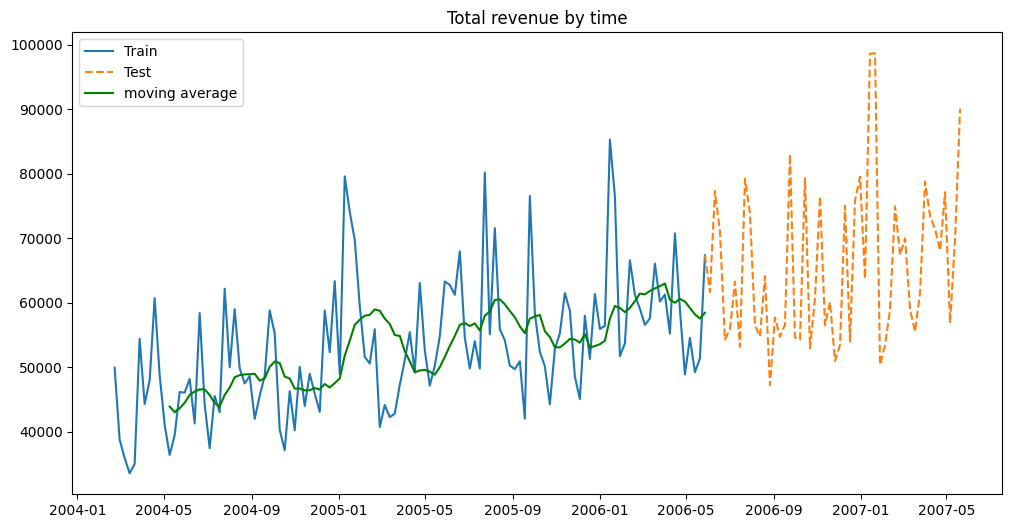

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', linestyle='dashed')
plt.plot(train.rolling(window=12).mean(),label = "moving average",color="green")
plt.legend()
plt.title('Total revenue by time')
plt.show()

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552 entries, 0 to 3551
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            3552 non-null   datetime64[ns]
 1   price           3552 non-null   float64       
 2   promotion       3552 non-null   int64         
 3   revenue         2720 non-null   float64       
 4   region_encoder  3552 non-null   int64         
 5   type_encoder    3552 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 166.6 KB


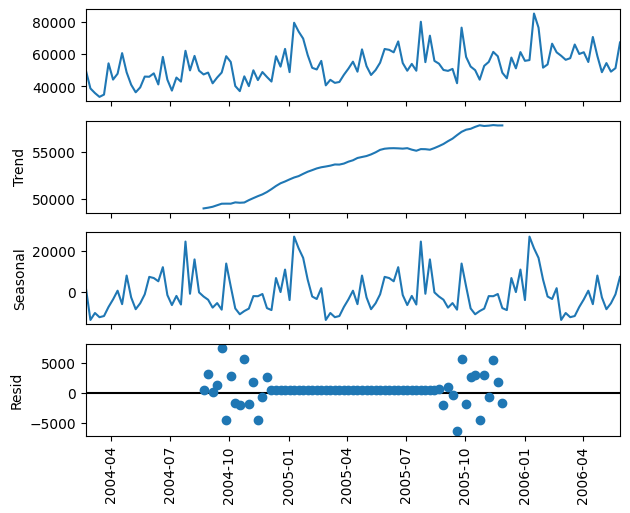

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(train)
decompose.plot()
plt.xticks(rotation = 90)
plt.show()


In [43]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(train["revenue"])

print("p-value = "+str(adf_test[1]))

p-value = 9.181281122534223e-05


our p-value < 0.05 , so the time series is stationary

<function matplotlib.pyplot.show(close=None, block=None)>

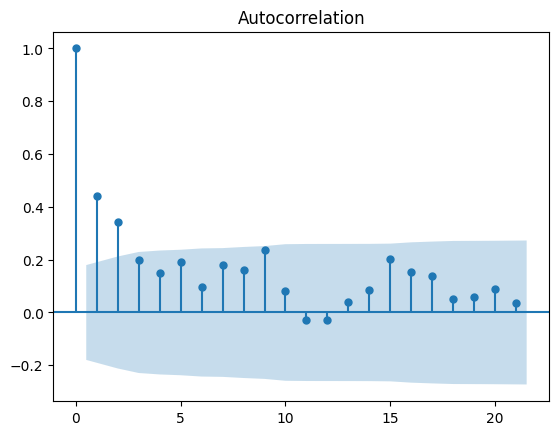

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(train["revenue"])
plt.axis('tight')
plt.show

In [45]:
from statsmodels.tsa.api import ExponentialSmoothing

model = ExponentialSmoothing(
                             train,
                             trend="add",
                             seasonal="add"                 
                            )

fit_model = model.fit()

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


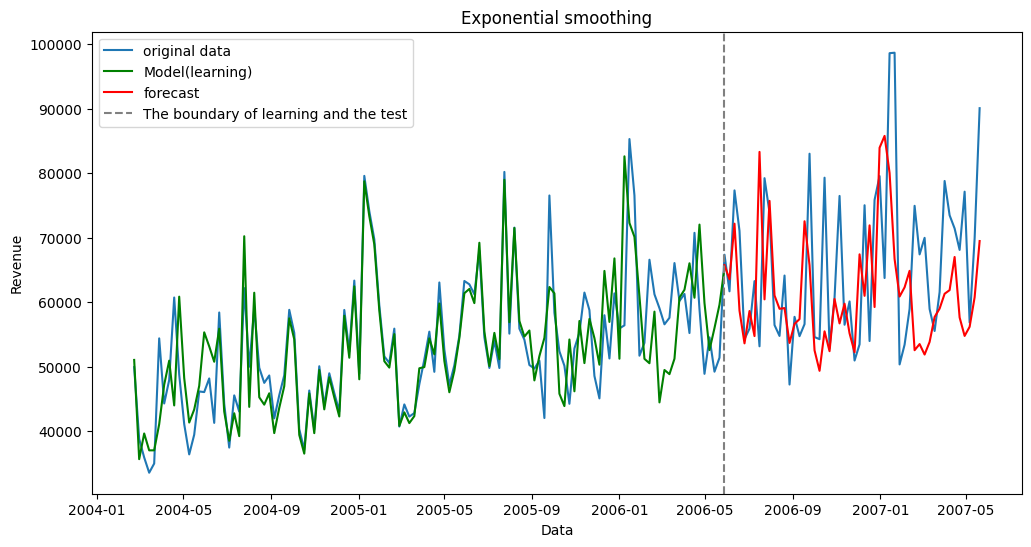

In [46]:
combined = pd.concat([train,test])
forecast = fit_model.forecast(steps = len(test))

plt.figure(figsize = (12,6))
plt.plot(combined.index, combined["revenue"],label = "original data")
plt.plot(train.index,fit_model.fittedvalues, label = "Model(learning)", color = "green")
plt.plot(test.index,forecast,label = "forecast", color = "red")
plt.axvline(x = train.index[-1],linestyle = '--', color = "gray", label = "The boundary of learning and the test")
plt.legend()
plt.title("Exponential smoothing")
plt.xlabel("Data")
plt.ylabel("Revenue")
plt.show()


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
test_flat = test.values.flatten()

mae = mean_absolute_error(test_flat,forecast)
mse = mean_squared_error(test_flat,forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_flat-forecast)/test_flat))*100


print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  10148.30
MSE:  172173663.63
RMSE: 13121.50
MAPE: 14.80%


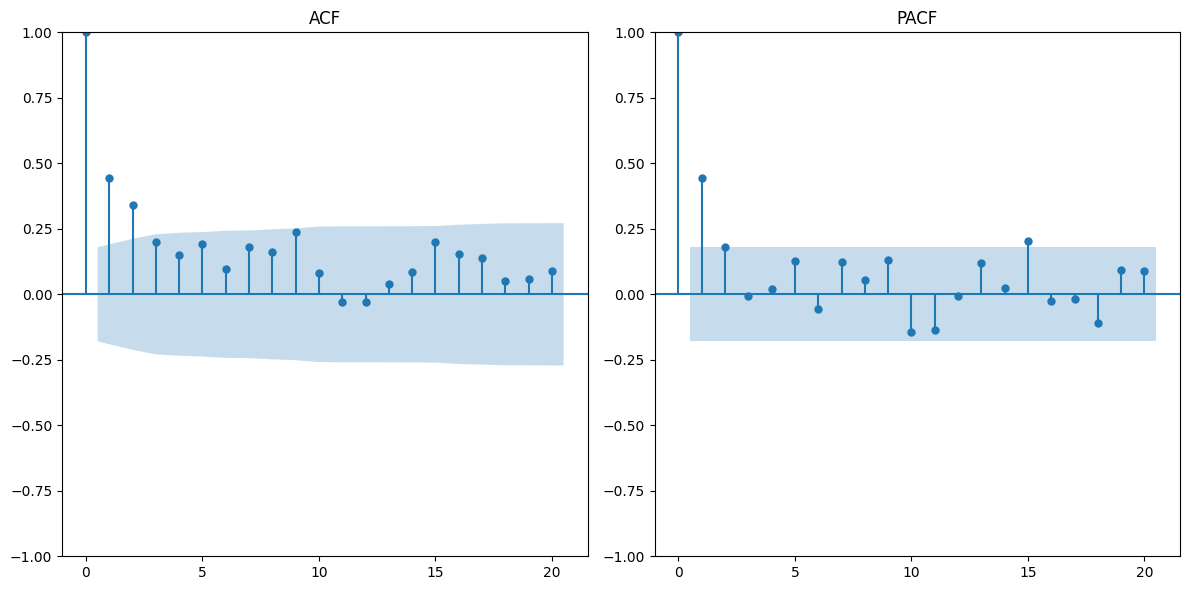

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(train, lags=20, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(train, lags=20, ax=plt.gca())
plt.title('PACF')

plt.tight_layout()
plt.show()


In [77]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(2, 0, 1))
fit_arima_model = arima_model.fit()

fit_arima_model.summary()

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                revenue   No. Observations:                  119
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1249.727
Date:                Fri, 21 Feb 2025   AIC                           2509.453
Time:                        02:08:45   BIC                           2523.349
Sample:                    02-22-2004   HQIC                          2515.096
                         - 05-28-2006                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.307e+04   1820.798     29.144      0.000    4.95e+04    5.66e+04
ar.L1          0.3110      0.604      0.515      0.607      -0.873       1.495
ar.L2          0.2076      0.255      0.814      0.416      -0.292       0.707
ma.L1          0.0550      0.635      0.087      0.931      -1.189       1.299
sigma2      7.637e+07      0.242   3.16e+08      0.000    7.64e+07    7.64e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                36.58
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             1.09
Prob(H) (two-sided):                  0.24   Kurtosis:                         4.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.27e+23. Standard errors may be unstable.
"""

In [78]:
arima_forecast = fit_arima_model.forecast(steps=52)

In [79]:
test_flat = test.values.flatten()

mae = mean_absolute_error(test_flat,arima_forecast)
mse = mean_squared_error(test_flat,arima_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_flat-arima_forecast)/test_flat))*100


print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  12671.22
MSE:  297893957.40
RMSE: 17259.60
MAPE: 16.95%


In [167]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
train_log = np.log1p(train)  
test_log = np.log1p(test)

sarima_model = SARIMAX(train_log,
                order=(1,1,1),
                seasonal_order=(1,1,1,52),
                enforce_stationarity=True,
                enforce_invertibility=False)
sarima_result = sarima_model.fit(disp=False)

/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/xlordplay/alfa_test_tasks/alfa_test/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [200]:
sarima_forecast = sarima_result.forecast(steps = len(test_flat))

test_flat = test.values.flatten()
mae = mean_absolute_error(test_flat,sarima_forecast)
mse = mean_squared_error(test_flat,sarima_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_flat-sarima_forecast)/test_flat))*100


print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE:  9590.45
MSE:  155719033.51
RMSE: 12478.74
MAPE: 13.99%


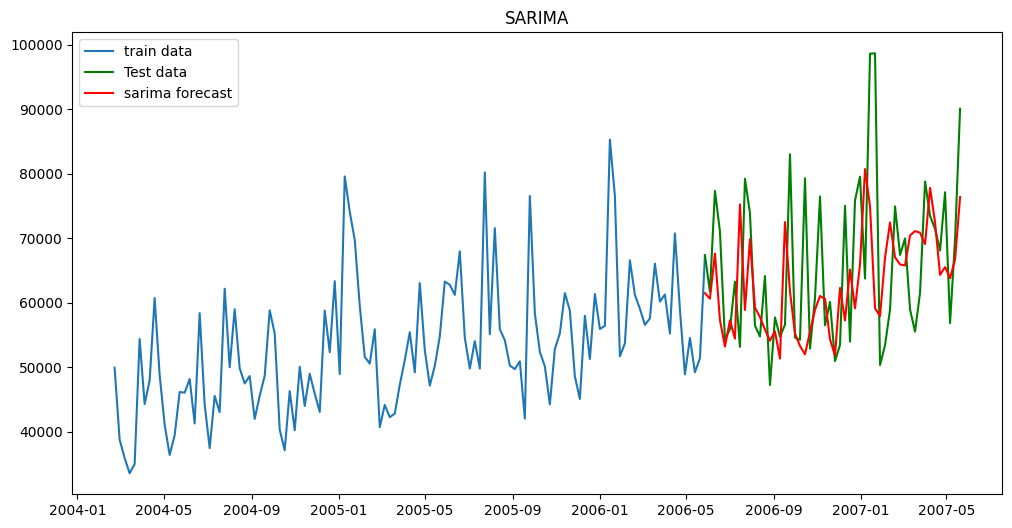

In [201]:
plt.figure(figsize = (12,6))
plt.plot(train ,label = "train data")
plt.plot(test, label = "Test data", color = "green")
plt.plot(test.index,sarima_forecast,label = "sarima forecast", color = "red")
plt.legend()
plt.title("SARIMA")
plt.show()